<a href="https://colab.research.google.com/github/rishikesh715/ADM/blob/main/Copy_of_RL_Assg_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.	Implementing TD-0 and SARSA algorithms for a grid-world environment.


PROMPT:                                                                          Implementing TD-0 and SARSA algorithms for a grid-world environment using function



Gymnasium example that shows TD(0) policy evaluation and SARSA control on a grid-world using FrozenLake-v1 (the classic tabular grid). It uses only NumPy + Gymnasium and runs on CPU.

![image.png](
  
)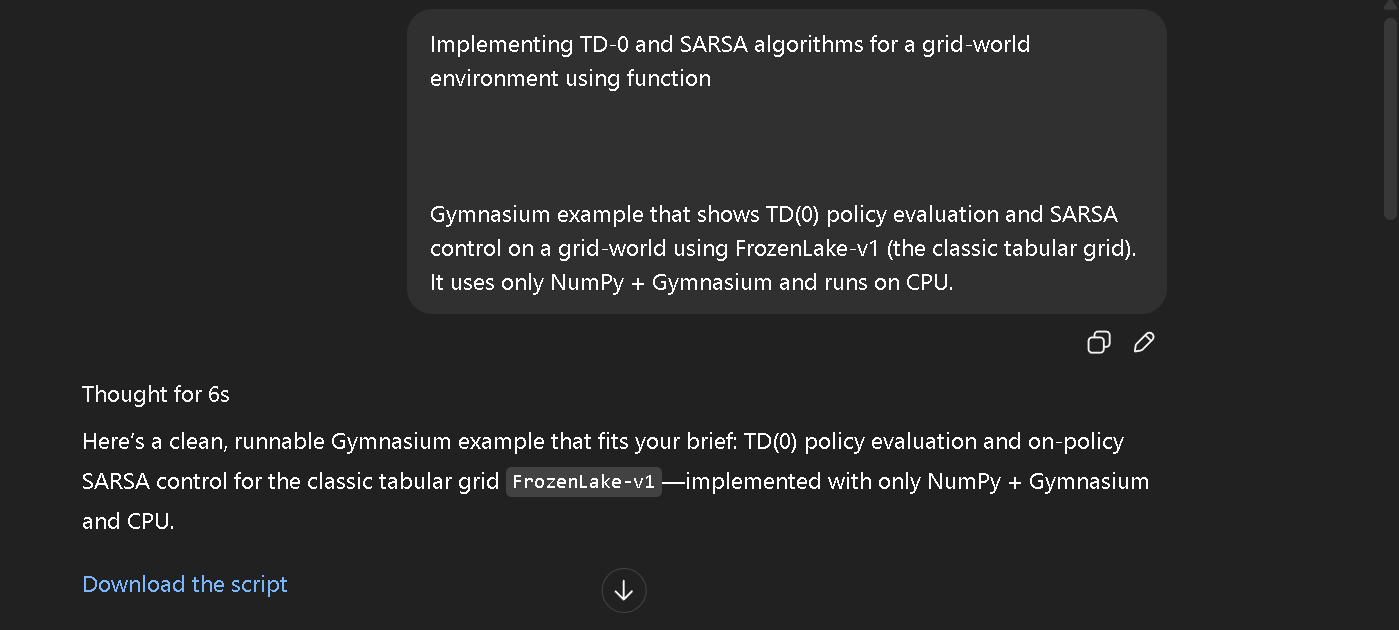

In [ ]:

#Gymnasium example that shows TD(0) policy evaluation and SARSA control on a grid-world using FrozenLake-v1 (the classic tabular grid). It uses only NumPy + Gymnasium and runs on CPU.

# td0_sarsa_frozenlake.py
# Gymnasium implementations of TD(0) and SARSA on a grid-world (FrozenLake-v1)

import gymnasium as gym
import numpy as np
from collections import defaultdict
from typing import Callable, Tuple

# ---------------------------
# Utilities
# ---------------------------

def epsilon_greedy(Q: np.ndarray, s: int, epsilon: float) -> int:
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    return int(np.argmax(Q[s]))

def run_episode(env, policy: Callable[[int], int], gamma: float = 0.99, max_steps: int = 1000) -> Tuple[float, int]:
    s, _ = env.reset()
    total_reward, steps = 0.0, 0
    for _ in range(max_steps):
        a = policy(s)
        s_next, r, terminated, truncated, _ = env.step(a)
        total_reward += r * (gamma ** steps)
        steps += 1
        s = s_next
        if terminated or truncated:
            break
    return total_reward, steps

# ---------------------------
# TD(0) Policy Evaluation
# ---------------------------

def td0_policy_evaluation(env_id: str = "FrozenLake-v1",
                          is_slippery: bool = True,
                          gamma: float = 0.99,
                          alpha: float = 0.1,
                          epsilon_random_policy: float = 1.0,
                          episodes: int = 20_000,
                          seed: int = 0) -> np.ndarray:
    """
    Estimates V^pi for a fixed policy using TD(0).
    By default, pi is a fully random policy (epsilon_random_policy = 1.0).
    """
    env = gym.make(env_id, is_slippery=is_slippery)
    rng = np.random.default_rng(seed)
    env.reset(seed=seed)

    nS = env.observation_space.n
    nA = env.action_space.n
    V = np.zeros(nS, dtype=np.float64)

    def policy(s: int) -> int:
        # Equiprobable random (or epsilon-random around greedy on V, but typically random)
        if rng.random() < epsilon_random_policy:
            return rng.integers(nA)
        # If not fully random, do a crude one-step lookahead using V (optional)
        return rng.integers(nA)

    for ep in range(episodes):
        s, _ = env.reset()
        done = False
        while not done:
            a = policy(s)
            s_next, r, terminated, truncated, _ = env.step(a)
            td_target = r + (0.0 if (terminated or truncated) else gamma * V[s_next])
            V[s] += alpha * (td_target - V[s])
            s = s_next
            done = terminated or truncated

    env.close()
    return V

# ---------------------------
# SARSA (on-policy TD control)
# ---------------------------

def sarsa_control(env_id: str = "FrozenLake-v1",
                  is_slippery: bool = True,
                  gamma: float = 0.99,
                  alpha: float = 0.1,
                  epsilon_start: float = 1.0,
                  epsilon_end: float = 0.05,
                  epsilon_decay_steps: int = 50_000,
                  episodes: int = 100_000,
                  max_steps_per_ep: int = 200,
                  seed: int = 1) -> Tuple[np.ndarray, np.ndarray]:
    """
    Learns an epsilon-greedy policy for Q using on-policy SARSA.
    Returns learned Q and the derived greedy policy (as a 1D array of actions).
    """
    env = gym.make(env_id, is_slippery=is_slippery)
    env.reset(seed=seed)
    rng = np.random.default_rng(seed)

    nS = env.observation_space.n
    nA = env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float64)

    def epsilon_by_step(t: int) -> float:
        # Linear decay
        frac = min(1.0, max(0.0, t / max(1, epsilon_decay_steps)))
        return epsilon_start + (epsilon_end - epsilon_start) * frac

    timestep = 0
    for ep in range(episodes):
        s, _ = env.reset()
        eps = epsilon_by_step(timestep)
        a = rng.integers(nA) if rng.random() < eps else int(np.argmax(Q[s]))
        for _ in range(max_steps_per_ep):
            s_next, r, terminated, truncated, _ = env.step(a)
            eps_next = epsilon_by_step(timestep + 1)
            a_next = rng.integers(nA) if rng.random() < eps_next else int(np.argmax(Q[s_next]))
            td_target = r + (0.0 if (terminated or truncated) else gamma * Q[s_next, a_next])
            Q[s, a] += alpha * (td_target - Q[s, a])

            timestep += 1
            s, a = s_next, a_next
            if terminated or truncated:
                break

    policy_greedy = np.argmax(Q, axis=1)
    env.close()
    return Q, policy_greedy

# ---------------------------
# Quick demo (optional)
# ---------------------------

if __name__ == "__main__":
    # TD(0) prediction under a random policy
    V = td0_policy_evaluation(
        env_id="FrozenLake-v1",
        is_slippery=True,   # set False for deterministic grid
        gamma=0.99,
        alpha=0.1,
        epsilon_random_policy=1.0,
        episodes=25_000,
        seed=42
    )
    print("TD(0) Value function estimate (V):")
    print(V.reshape(4, 4))  # for 4x4 FrozenLake

    # SARSA control to learn a policy
    Q, pi = sarsa_control(
        env_id="FrozenLake-v1",
        is_slippery=True,
        gamma=0.99,
        alpha=0.1,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay_steps=80_000,
        episodes=120_000,
        max_steps_per_ep=200,
        seed=7
    )
    print("\nGreedy policy from SARSA (actions 0:Left, 1:Down, 2:Right, 3:Up):")
    print(pi.reshape(4, 4))
    print("\nState-action values Q[s,a] (reshaped per action for readability):")
    for a in range(Q.shape[1]):
        print(f"Action {a}:")
        print(Q[:, a].reshape(4, 4))




TD(0) Value function estimate (V):
[[0.01154136 0.00756639 0.02747178 0.013248  ]
 [0.01991066 0.         0.0626995  0.        ]
 [0.03684871 0.0758343  0.18880016 0.        ]
 [0.         0.16529731 0.52072376 0.        ]]

Greedy policy from SARSA (actions 0:Left, 1:Down, 2:Right, 3:Up):
[[0 3 1 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]

State-action values Q[s,a] (reshaped per action for readability):
Action 0:
[[0.35879099 0.256256   0.2354679  0.12917957]
 [0.40523588 0.         0.15157585 0.        ]
 [0.2666601  0.318245   0.56247467 0.        ]
 [0.         0.30634394 0.63039223 0.        ]]
Action 1:
[[0.31427124 0.19830804 0.24873389 0.11229348]
 [0.23471058 0.         0.169121   0.        ]
 [0.26211337 0.56930223 0.30913391 0.        ]
 [0.         0.38829745 0.85720356 0.        ]]
Action 2:
[[0.2981604  0.10287446 0.2361989  0.14233501]
 [0.24663785 0.         0.21868749 0.        ]
 [0.25617631 0.40590125 0.30485473 0.        ]
 [0.         0.70056179 0.62130542 0.        ]]


In [ ]:
#!/usr/bin/env python3
"""
FrozenLake TD(0) Policy Evaluation + SARSA Control (NumPy + Gymnasium)

- TD(0) policy evaluation on a *given* policy (e.g., random or greedy from Q)
- On-policy SARSA control to learn a near-optimal policy
- Works with FrozenLake-v1 (tabular), CPU-only
- No external plotting libs required

Usage (examples):
  python frozenlake_td_sarsa.py --mode eval --episodes 20000 --slippery
  python frozenlake_td_sarsa.py --mode sarsa --episodes 50000 --epsilon 0.1 --alpha 0.1 --slippery
  python frozenlake_td_sarsa.py --mode both --episodes 50000 --epsilon 0.1 --alpha 0.1 --deterministic
"""

from __future__ import annotations
# Removed argparse import
import numpy as np

try:
    import gymnasium as gym
except ImportError as e:
    raise SystemExit(
        "Gymnasium is required. Install with: pip install gymnasium[classic-control] or gymnasium[toy_text]"
    ) from e


# -----------------------------
# Environment helpers
# -----------------------------
def make_env(slippery: bool, seed: int | None = 42):
    env = gym.make("FrozenLake-v1", is_slippery=slippery)
    # set seeds for reproducibility
    if seed is not None:
        env.reset(seed=seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        np.random.seed(seed)
    return env


def nS_nA(env):
    assert hasattr(env.observation_space, "n") and hasattr(env.action_space, "n"), \
        "This example expects discrete (tabular) observation/action spaces."
    return env.observation_space.n, env.action_space.n


# -----------------------------
# Policies
# -----------------------------
def random_policy(nA: int) -> np.ndarray:
    """Return a uniform action-probability vector π(a|s)=1/nA."""
    return np.ones(nA) / nA


def epsilon_greedy_action(Q: np.ndarray, s: int, epsilon: float, nA: int, rng: np.random.Generator) -> int:
    if rng.random() < epsilon:
        return rng.integers(0, nA)
    # break ties uniformly among argmax actions
    q = Q[s]
    max_q = np.max(q)
    candidates = np.flatnonzero(np.isclose(q, max_q))
    return int(rng.choice(candidates))


# -----------------------------
# TD(0) Policy Evaluation
# -----------------------------
def td0_policy_evaluation(env, policy_probs: np.ndarray, gamma: float = 0.99, alpha: float = 0.1,
                          episodes: int = 50_000, seed: int | None = 123) -> np.ndarray:
    """
    Evaluate a *fixed* policy using TD(0).

    Args:
        env: Gymnasium FrozenLake-v1 environment
        policy_probs: shape [nS, nA] with π(a|s)
        gamma: discount
        alpha: step-size
        episodes: number of episodes
        seed: RNG seed for action exploration (episode starts)

    Returns:
        V: state-value estimates, shape [nS]
    """
    nS, nA = nS_nA(env)
    assert policy_probs.shape == (nS, nA), "policy_probs must be [nS, nA]"
    V = np.zeros(nS, dtype=np.float64)
    rng = np.random.default_rng(seed)

    for _ in range(episodes):
        s, _ = env.reset()
        terminated = truncated = False

        while not (terminated or truncated):
            a = rng.choice(nA, p=policy_probs[s])
            s_next, r, terminated, truncated, _info = env.step(a)
            td_target = r + gamma * V[s_next] * (0 if (terminated or truncated) else 1)
            V[s] += alpha * (td_target - V[s])
            s = s_next

    return V


# -----------------------------
# SARSA Control (on-policy)
# -----------------------------
def sarsa_control(env, gamma: float = 0.99, alpha: float = 0.1, epsilon: float = 0.1,
                  episodes: int = 100_000, epsilon_decay: float = 1.0,
                  min_epsilon: float = 0.01, seed: int | None = 321):
    """
    On-policy SARSA control to learn Q and an ε-greedy policy.

    Args:
        env: Gymnasium FrozenLake-v1 environment
        gamma, alpha: RL hyperparameters
        epsilon: initial ε for ε-greedy
        episodes: number of episodes
        epsilon_decay: multiply ε by this each episode (<=1.0). 1.0 means no decay.
        min_epsilon: lower bound if decaying
        seed: RNG seed

    Returns:
        Q: action-value table [nS, nA]
        policy: greedy policy derived from Q (deterministic, shape [nS])
        returns: list of episodic returns during training
    """
    nS, nA = nS_nA(env)
    Q = np.zeros((nS, nA), dtype=np.float64)
    rng = np.random.default_rng(seed)
    eps = epsilon
    returns = []

    for ep in range(episodes):
        s, _ = env.reset()
        a = epsilon_greedy_action(Q, s, eps, nA, rng)
        terminated = truncated = False
        G = 0.0

        while not (terminated or truncated):
            s_next, r, terminated, truncated, _info = env.step(a)
            G += r
            if terminated or truncated:
                td_target = r  # no bootstrap on terminal
                Q[s, a] += alpha * (td_target - Q[s, a])
                break

            a_next = epsilon_greedy_action(Q, s_next, eps, nA, rng)
            td_target = r + gamma * Q[s_next, a_next]
            Q[s, a] += alpha * (td_target - Q[s, a])
            s, a = s_next, a_next

        returns.append(G)
        # decay epsilon if configured
        eps = max(min_epsilon, eps * epsilon_decay)

    policy = np.argmax(Q, axis=1)
    return Q, policy, returns


# -----------------------------
# Utility / Evaluation
# -----------------------------
def greedy_policy_from_Q(Q: np.ndarray) -> np.ndarray:
    return np.argmax(Q, axis=1)


def policy_to_probs(policy: np.ndarray, nA: int) -> np.ndarray:
    """Convert a deterministic policy array [nS] -> probs [nS, nA]."""
    nS = policy.shape[0]
    probs = np.zeros((nS, nA), dtype=np.float64)
    probs[np.arange(nS), policy] = 1.0
    return probs


def run_episodes(env, policy: np.ndarray, episodes: int = 1_000, seed: int | None = 7):
    """Evaluate deterministic policy by average return over episodes."""
    rng = np.random.default_rng(seed)
    nS, nA = nS_nA(env)
    assert policy.shape == (nS,), "policy must be shape [nS] with integer actions"
    total = 0.0
    for _ in range(episodes):
        s, _ = env.reset(seed=int(rng.integers(0, 10_000)))
        terminated = truncated = False
        G = 0.0
        while not (terminated or truncated):
            a = int(policy[s])
            s, r, terminated, truncated, _ = env.step(a)
            G += r
        total += G
    return total / episodes


def print_value_table(V: np.ndarray, env, title: str = "State Values V(s)"):
    nS, _ = nS_nA(env)
    size = int(np.sqrt(nS))
    print(f"\n{title}")
    for r in range(size):
        row = V[r * size:(r + 1) * size]
        print(" ".join(f"{v:6.3f}" for v in row))


def print_policy(policy: np.ndarray, env, title: str = "Policy (0=Left,1=Down,2=Right,3=Up)"):
    nS, nA = nS_nA(env)
    size = int(np.sqrt(nS))
    arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    print(f"\n{title}")
    for r in range(size):
        row = policy[r * size:(r + 1) * size]
        print(" ".join(arrows.get(int(a), '?') for a in row))


# -----------------------------
# Demo (optional)
# -----------------------------

# TD(0) prediction under a random policy
env = make_env(slippery=True, seed=42)
nS, nA = nS_nA(env)
pi = np.tile(random_policy(nA), (nS, 1))  # [nS, nA]
V = td0_policy_evaluation(env, pi, gamma=0.99, alpha=0.1, episodes=25_000, seed=123)
print_value_table(V, env, title="TD(0) Value Estimates for Random Policy")
env.close()

# SARSA control to learn a policy
env = make_env(slippery=True, seed=7)
Q, policy, returns = sarsa_control(
    env,
    gamma=0.99,
    alpha=0.1,
    epsilon=1.0,
    episodes=120_000,
    epsilon_decay=0.999,
    min_epsilon=0.05,
    seed=321
)
print_policy(policy, env, title="Greedy Policy from SARSA Q")
avg_return = run_episodes(env, policy, episodes=2000, seed=7)
print(f"\nEvaluation: average return over 2000 episodes = {avg_return:.3f}")

env.close()


TD(0) Value Estimates for Random Policy
 0.021  0.018  0.028  0.008
 0.022  0.000  0.043  0.000
 0.037  0.105  0.135  0.000
 0.000  0.203  0.369  0.000

Greedy Policy from SARSA Q
← ↑ ← ↑
← ← → ←
↑ ↓ ← ←
← → ↓ ←

Evaluation: average return over 2000 episodes = 0.723
